In [1]:
!pip install optuna

import warnings

# Отключаем все предупреждения
warnings.filterwarnings("ignore")

import xgboost as xgb
import optuna # Add this line to import the optuna module
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

In [3]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [4]:
train['num_sold'].isna().sum()

8871

In [5]:
train[['country', 'store', 'product']].apply(lambda col: col.unique()).to_dict()

{'country': array(['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore'],
       dtype=object),
 'store': array(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
       dtype=object),
 'product': array(['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler',
        'Kerneler Dark Mode'], dtype=object)}

In [6]:
test[['country', 'store', 'product']].apply(lambda col: col.unique()).to_dict()

{'country': array(['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore'],
       dtype=object),
 'store': array(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
       dtype=object),
 'product': array(['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler',
        'Kerneler Dark Mode'], dtype=object)}

In [7]:
train[train['num_sold'].isna()]

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
45,45,2010-01-01,Kenya,Discount Stickers,Holographic Goose,NaN
90,90,2010-01-02,Canada,Discount Stickers,Holographic Goose,NaN
135,135,2010-01-02,Kenya,Discount Stickers,Holographic Goose,NaN
180,180,2010-01-03,Canada,Discount Stickers,Holographic Goose,NaN
...,...,...,...,...,...,...
229905,229905,2016-12-29,Kenya,Discount Stickers,Holographic Goose,NaN
229950,229950,2016-12-30,Canada,Discount Stickers,Holographic Goose,NaN
229995,229995,2016-12-30,Kenya,Discount Stickers,Holographic Goose,NaN
230040,230040,2016-12-31,Canada,Discount Stickers,Holographic Goose,NaN


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        230130 non-null  int64         
 1   date      230130 non-null  datetime64[ns]
 2   country   230130 non-null  object        
 3   store     230130 non-null  object        
 4   product   230130 non-null  object        
 5   num_sold  221259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 10.5+ MB


# EDA

## lineplot

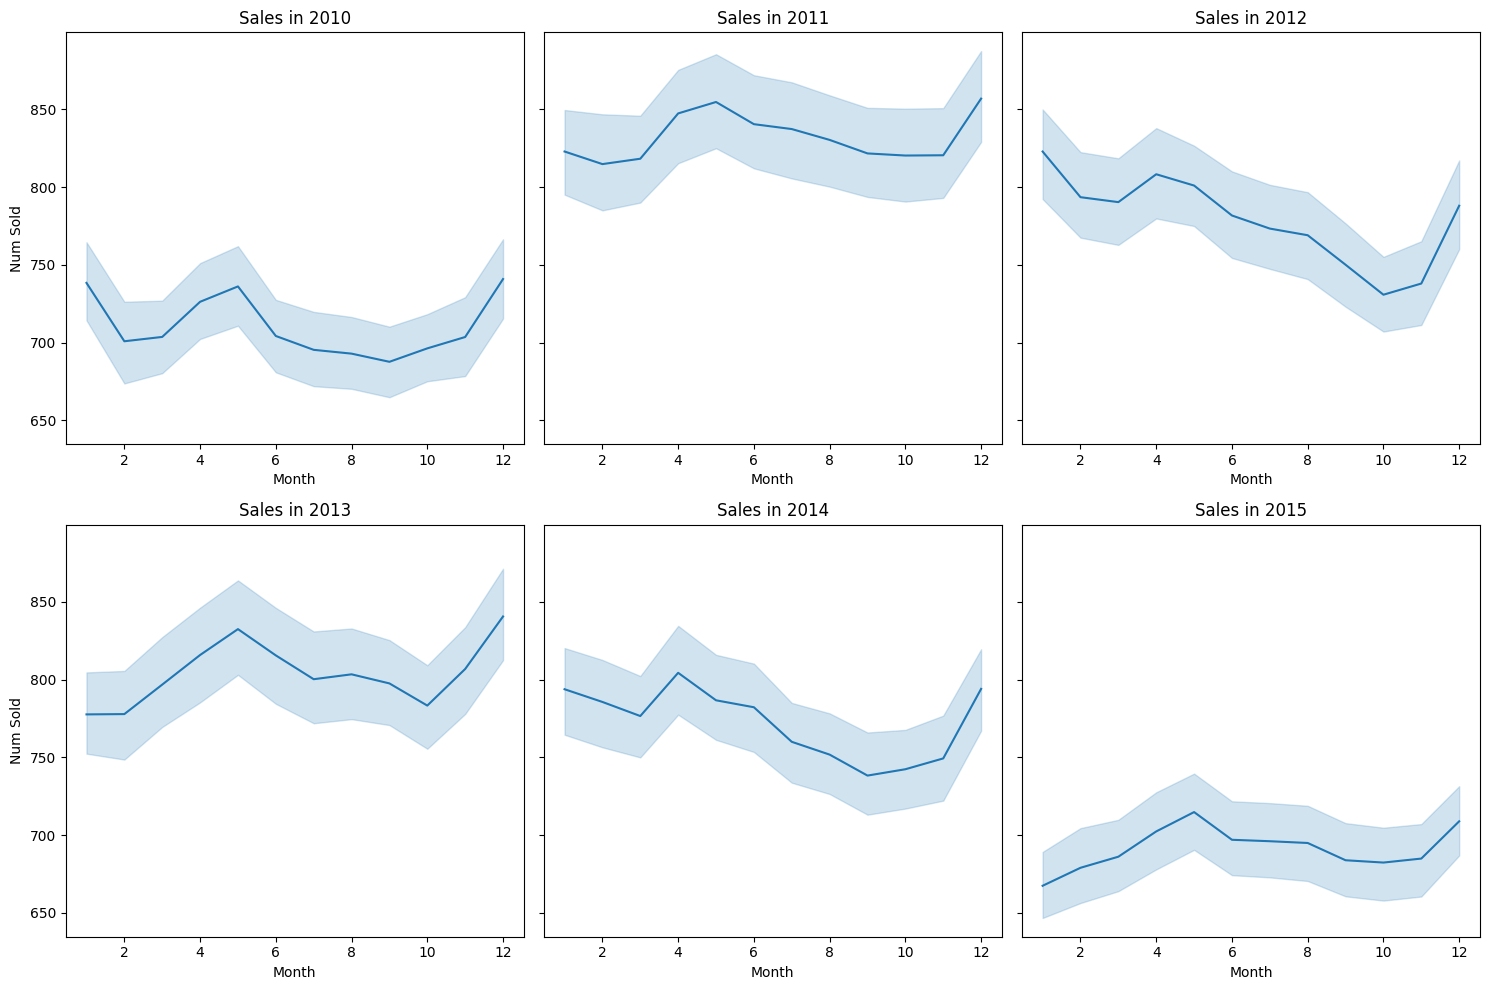

In [9]:
# Задаем параметры фигуры
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

# Генерируем графики по годам
for i, year in enumerate(range(2010, 2016)):
    ax = axes[i // 3, i % 3]  # Определяем положение в сетке
    sns.lineplot(
        data=train[train['date'].dt.year == year],
        x=train[train['date'].dt.year == year]['date'].dt.month,
        y='num_sold',
        ax=ax
    )
    ax.set_title(f'Sales in {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Num Sold')

# Очищаем и упорядочиваем
plt.tight_layout()

Text(0.5, 1.0, 'Sold Year-Product')

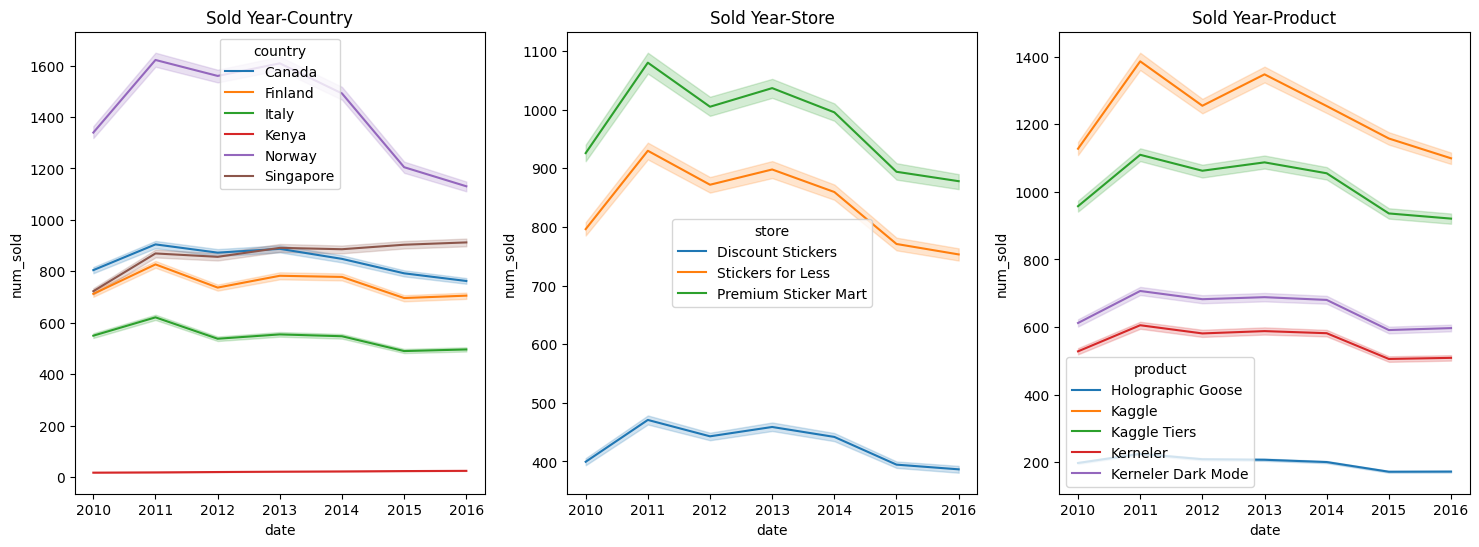

In [10]:
fit, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.lineplot(data = train, x = train['date'].dt.year, y = train['num_sold'], hue = train['country'], ax = axes[0])
axes[0].set_title('Sold Year-Country')

sns.lineplot(data = train, x = train['date'].dt.year, y = train['num_sold'], hue = train['store'], ax = axes[1])
axes[1].set_title('Sold Year-Store')

sns.lineplot(data = train, x = train['date'].dt.year, y = train['num_sold'], hue = train['product'], ax = axes[2])
axes[2].set_title('Sold Year-Product')

Text(0.5, 1.0, 'Sold Month-Product')

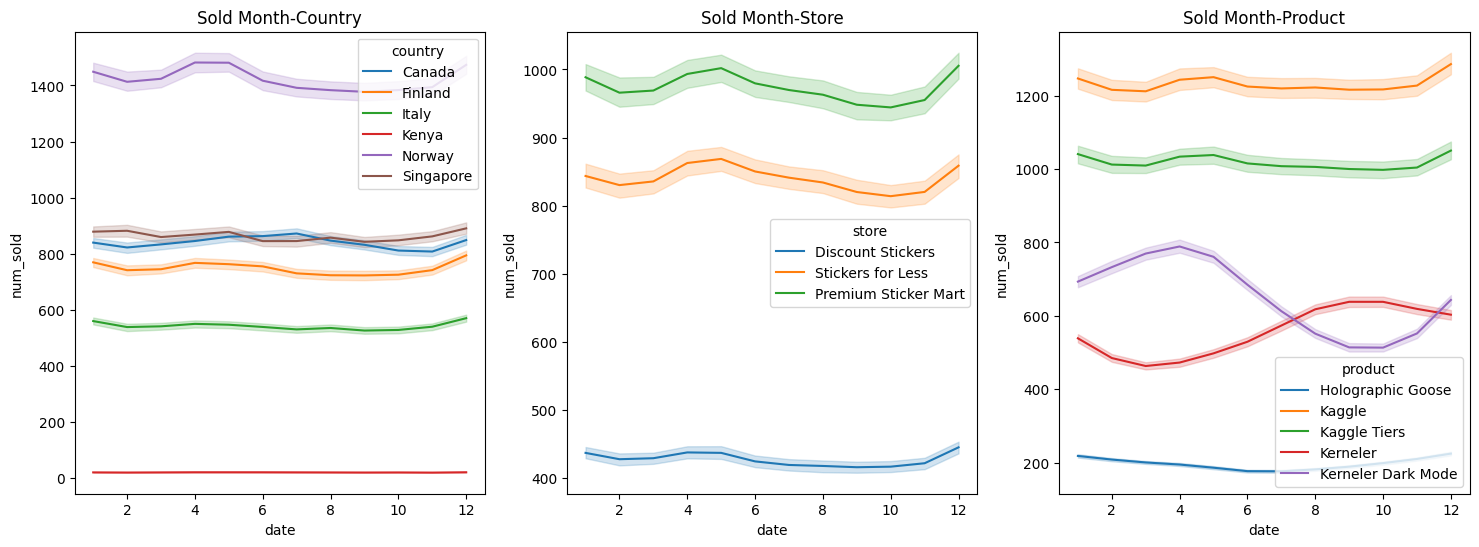

In [11]:
fit, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.lineplot(data = train, x = train['date'].dt.month, y = train['num_sold'], hue = train['country'], ax = axes[0])
axes[0].set_title('Sold Month-Country')

sns.lineplot(data = train, x = train['date'].dt.month, y = train['num_sold'], hue = train['store'], ax = axes[1])
axes[1].set_title('Sold Month-Store')

sns.lineplot(data = train, x = train['date'].dt.month, y = train['num_sold'], hue = train['product'], ax = axes[2])
axes[2].set_title('Sold Month-Product')

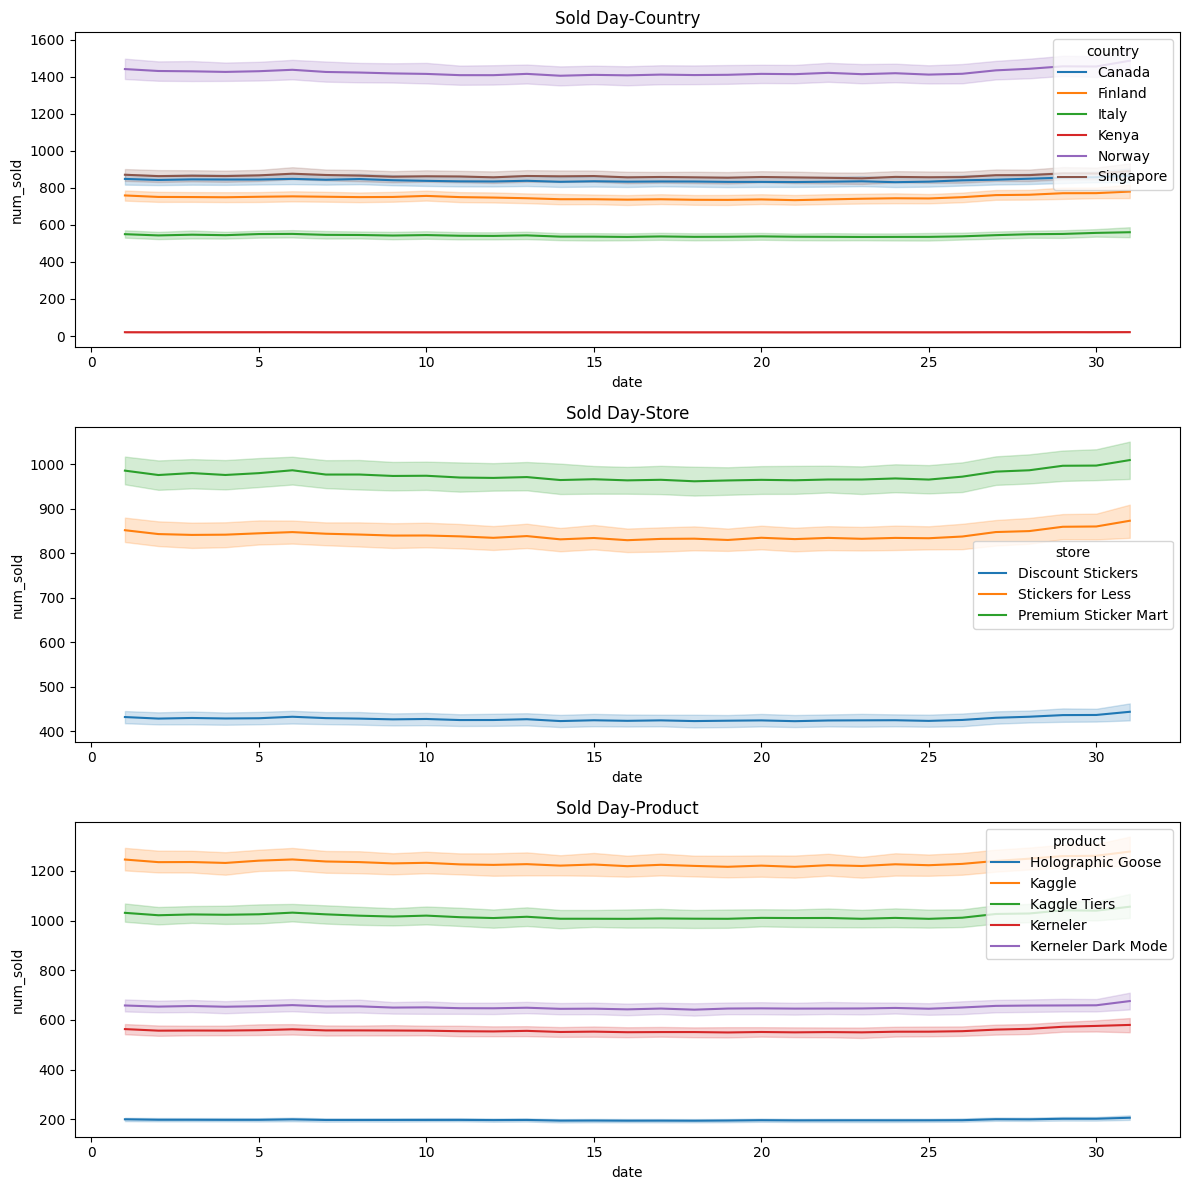

In [12]:
fit, axes = plt.subplots(3, 1, figsize=(12, 12))  # Увеличиваем высоту фигуры

sns.lineplot(data=train, x=train['date'].dt.day, y=train['num_sold'], hue=train['country'], ax=axes[0])
axes[0].set_title('Sold Day-Country')

sns.lineplot(data=train, x=train['date'].dt.day, y=train['num_sold'], hue=train['store'], ax=axes[1])
axes[1].set_title('Sold Day-Store')

sns.lineplot(data=train, x=train['date'].dt.day, y=train['num_sold'], hue=train['product'], ax=axes[2])
axes[2].set_title('Sold Day-Product')

# Применяем автоматическое выравнивание
plt.tight_layout()

## barplot

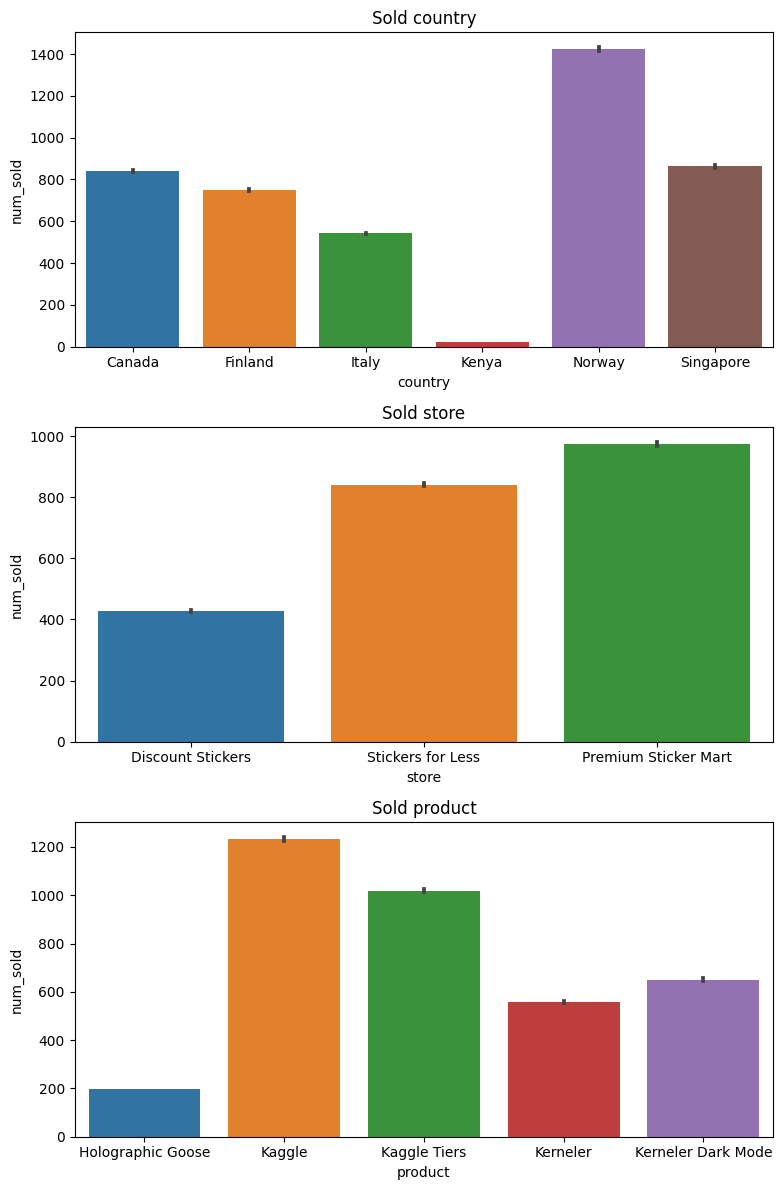

In [13]:
fig, axes = plt.subplots(3, 1, figsize = (8, 12))

sns.barplot(data = train, x = train['country'], y = train['num_sold'], ax = axes[0])
axes[0].set_title('Sold country')

sns.barplot(data = train, x = train['store'], y = train['num_sold'], ax = axes[1])
axes[1].set_title('Sold store')

sns.barplot(data = train, x = train['product'], y = train['num_sold'], ax = axes[2])
axes[2].set_title('Sold product')

plt.tight_layout()

## seasonal_decompose

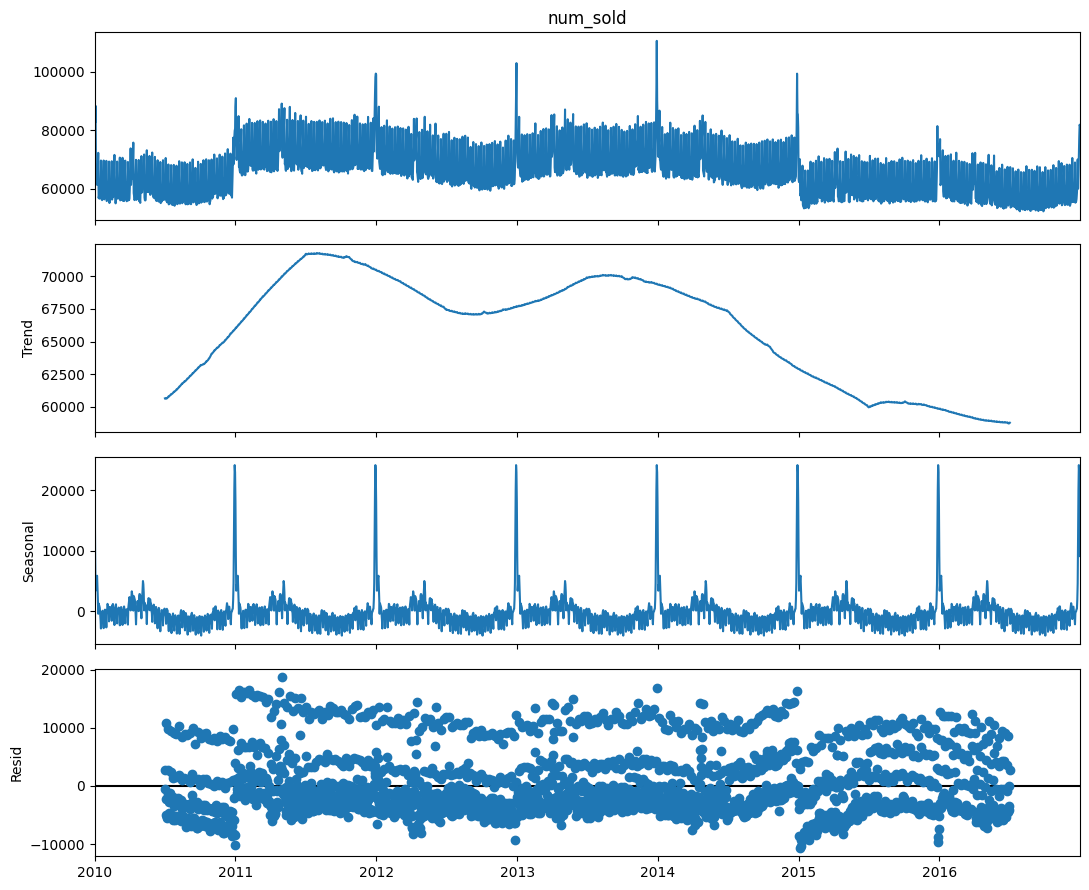

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

series = train.copy()

# Преобразуем дату в индекс и выбираем столбец
series.set_index('date', inplace=True)

# Группируем данные по индексу (дате) и агрегируем
series = series.groupby(series.index).sum()

series = series['num_sold'].asfreq('D')  # Устанавливаем дневную частоту

# Задаем размер графика
rcParams['figure.figsize'] = 11, 9

# Применяем seasonal_decompose
decompose = seasonal_decompose(series, model='additive', period=365)
decompose.plot()
plt.show()


# Model

In [15]:
def generate_time_features(df, date_column, add_trend_seasonality=False):

    # Основные временные признаки
    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month
    df['day'] = df[date_column].dt.day
    df['day_of_week'] = df[date_column].dt.dayofweek  # Понедельник = 0, Воскресенье = 6
    df['day_of_year'] = df[date_column].dt.dayofyear  # День года
    df['week_of_year'] = df[date_column].dt.isocalendar().week  # Номер недели

    # Периодические признаки (синус/косинус для циклической природы времени)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    df['sin_day_of_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_day_of_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.0)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.0)
    df['year_sin'] = np.sin(2 * np.pi * df['year'] / 7.0)
    df['year_cos'] = np.cos(2 * np.pi * df['year'] / 7.0)

    # Декомпозиция временного ряда и сезонные компоненты
    df['group'] = (df['year'] - 2010) * 48 + df['month'] * 4 + df['day'] // 7  # Группировка по периодам

    # Признаки тренда и сезонности
    if add_trend_seasonality:
        df['linear_trend'] = (df[date_column] - df[date_column].min()).dt.days  # Линейный тренд
        df['seasonality_month'] = np.sin(2 * np.pi * df['month'] / 12) * np.cos(2 * np.pi * df['month'] / 12)
        df['seasonality_week'] = np.sin(2 * np.pi * df['week_of_year'] / 52)

	  # Добавление полиномиального тренда
    df["squared_trend"] = np.square(np.arange(len(df)))

    return df

In [16]:
# Добавляем целевую переменную в тестовые данные временно, чтобы объединить для факторизации
train['is_test'] = 0
test['is_test'] = 1
test['num_sold'] = np.nan

train = train.dropna()

# Объединение данных для факторизации
combined = pd.concat([train, test], axis=0, ignore_index=True)

In [17]:
data = generate_time_features(combined, 'date', True)

In [18]:
# Указываем, какие признаки являются категориальными
categorical_features = ['country', 'store', 'product']

data = pd.get_dummies(data, columns=categorical_features)

# Разделение обратно на train и test
train = data[data['is_test'] == 0].drop(columns=['is_test'])
test = data[data['is_test'] == 1].drop(columns=['is_test', 'num_sold'])

In [19]:
# Логарифмирование целевой переменной
train['num_sold'] = np.log1p(train['num_sold'])

# Определение признаков и целевой переменной
X = train.drop(columns=['num_sold', 'date', 'id'])
y = train['num_sold']

test_X = test.drop(columns=['date', 'id'])

In [20]:
"""
# Оптимизация гиперпараметров с Optuna
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',  # Валидационная метрика
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.1, 10.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 10.0)
    }

    # Временная кросс-валидация
    tscv = TimeSeriesSplit(n_splits=5)
    mape_scores = []

    for train_idx, valid_idx in tscv.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # Модель XGBoost
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=0
        )

        # Оценка MAPE
        y_pred = model.predict(X_valid)
        mape_scores.append(mean_absolute_percentage_error(y_valid, y_pred))

    return np.mean(mape_scores)

# Запуск Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=60)

# Вывод лучших параметров
print("Best parameters:", study.best_params)
"""

'\n# Оптимизация гиперпараметров с Optuna\ndef objective(trial):\n    params = {\n        \'objective\': \'reg:squarederror\',\n        \'eval_metric\': \'mae\',  # Валидационная метрика\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 1000),\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 0.01, 0.3),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 12),\n        \'min_child_weight\': trial.suggest_loguniform(\'min_child_weight\', 0.1, 10.0),\n        \'gamma\': trial.suggest_loguniform(\'gamma\', 1e-4, 1.0),\n        \'subsample\': trial.suggest_uniform(\'subsample\', 0.5, 1.0),\n        \'colsample_bytree\': trial.suggest_uniform(\'colsample_bytree\', 0.5, 1.0),\n        \'reg_alpha\': trial.suggest_loguniform(\'reg_alpha\', 1e-4, 10.0),\n        \'reg_lambda\': trial.suggest_loguniform(\'reg_lambda\', 1e-4, 10.0)\n    }\n\n    # Временная кросс-валидация\n    tscv = TimeSeriesSplit(n_splits=5)\n    mape_scores = []\n\n    for tra

In [21]:
# Финальное обучение модели с лучшими параметрами
best_params = {'n_estimators': 390,
               'learning_rate': 0.20666639154849473,
               'max_depth': 4,
               'min_child_weight': 5.033477964394619,
               'gamma': 0.0018222194114154585,
               'subsample': 0.5684310524197911,
               'colsample_bytree': 0.7894123599173396,
               'reg_alpha': 0.9584057575744531,
               'reg_lambda': 0.004188524198551127}


final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7894123599173396, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.0018222194114154585,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.20666639154849473,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=5.033477964394619, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=390,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

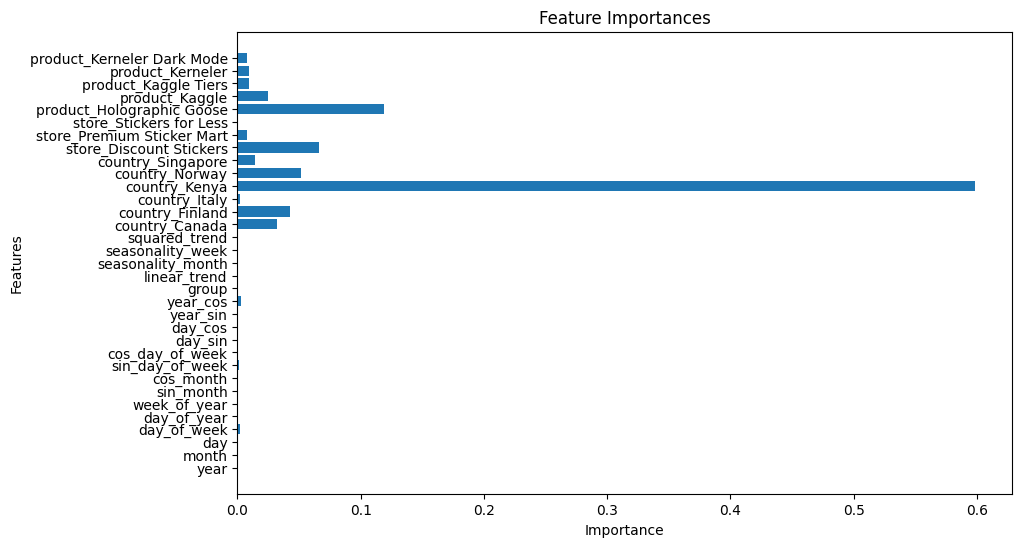

In [22]:
# Важность признаков
feature_importances = final_model.feature_importances_
feature_names = X.columns

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [23]:
# Предсказания для тестового набора
test['num_sold'] = np.expm1(final_model.predict(test_X))

# Подготовка файла для отправки
submission = test[['id', 'num_sold']]
submission['num_sold'] = submission['num_sold'].round().astype(int)
submission.to_csv('submission.csv', index=False)

In [24]:
submission

,id,num_sold
221259,230130,158
221260,230131,883
221261,230132,703
221262,230133,391
221263,230134,463
...,...,...
319804,328675,389
319805,328676,2546
319806,328677,1972
319807,328678,1111
